In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import tensorflow as tf



In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 20
CHANNELS=3

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "FoodImages",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = (BATCH_SIZE)
)

Found 3327 files belonging to 23 classes.


In [7]:
class_names = dataset.class_names
class_names

['beef_carpaccio',
 'beet_salad',
 'breakfast_burrito',
 'chicken_curry',
 'chicken_wings',
 'cup_cakes',
 'eggs_benedict',
 'falafel',
 'french_fries',
 'fried_rice',
 'frozen_yogurt',
 'greek_salad',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'ice_cream',
 'macaroni_and_cheese',
 'omelette',
 'onion_rings',
 'pizza',
 'samosa',
 'spring_rolls',
 'waffles']

In [8]:
len(dataset)

416

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(8, 256, 256, 3)
[14  7  5 19 13 22  2 18]


In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[ 36.75   5.75  10.75]
  [ 36.75   8.5   12.25]
  [ 33.     7.5   10.5 ]
  ...
  [191.75 159.75 100.75]
  [194.   164.5   99.  ]
  [192.5  163.5   94.5 ]]

 [[ 40.     9.    14.  ]
  [ 38.25   8.75  13.  ]
  [ 36.     9.5   12.75]
  ...
  [196.   163.75 107.  ]
  [197.25 165.75 103.  ]
  [198.25 169.25 102.25]]

 [[ 39.75   7.75  10.75]
  [ 41.     9.5   12.25]
  [ 39.75   9.5   11.75]
  ...
  [196.75 164.   109.25]
  [196.25 164.25 105.25]
  [200.   168.25 107.  ]]

 ...

 [[145.   102.    49.  ]
  [149.   103.    53.  ]
  [148.   100.    54.  ]
  ...
  [175.25 114.75  52.  ]
  [168.25 106.    49.25]
  [166.5  103.5   52.  ]]

 [[148.5  105.5   52.5 ]
  [153.25 107.25  57.25]
  [151.5  103.5   57.5 ]
  ...
  [173.   114.75  52.5 ]
  [170.75 109.75  54.  ]
  [170.25 106.75  57.25]]

 [[147.25 104.25  51.25]
  [151.25 105.25  55.25]
  [150.5  102.5   56.5 ]
  ...
  [171.25 112.75  51.25]
  [169.5  108.5   53.  ]
  [164.5  102.5   54.5 ]]]


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

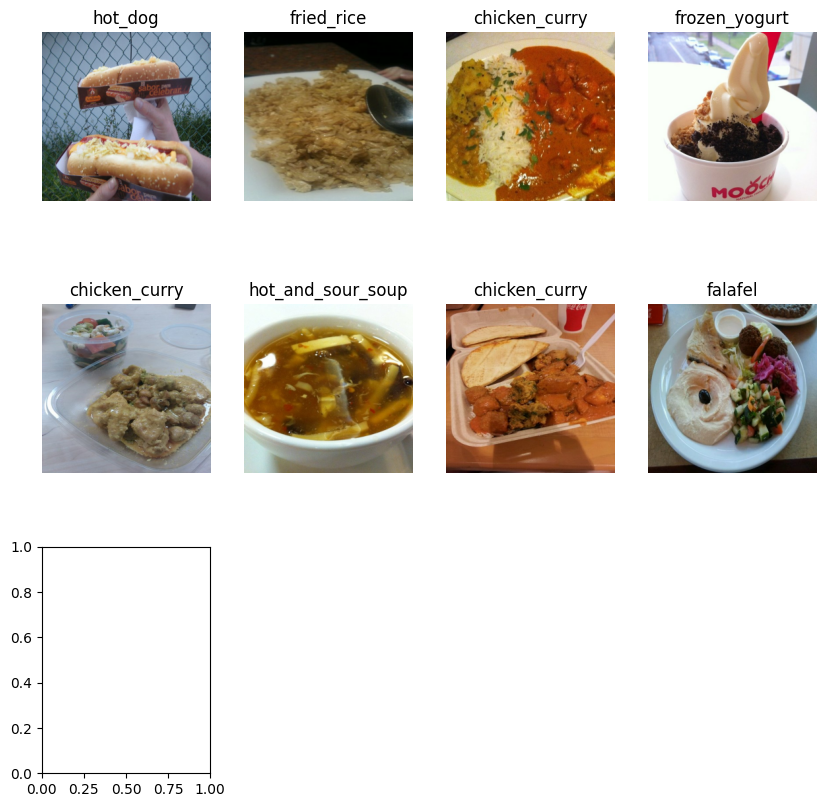

In [11]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [15]:
train_size = 0.8 
len(dataset)*train_size

332.8

In [16]:
train_ds = dataset.take(332)
len(train_ds)

332

In [17]:
test_ds = dataset.skip(332)
len(test_ds)

84

In [18]:
 val_size = 0.1 
 len(dataset)*val_size

41.6

In [19]:
val_ds = test_ds.take(41)
len(val_ds)

41

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

332

In [23]:
len(val_ds)

41

In [24]:
len(test_ds)

43

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 37

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (8, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (8, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2  (8, 127, 127, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (8, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (8, 62, 62, 64)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (8, 60, 60, 64)          

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/25
332/332 [==============================] - 87s 254ms/step - loss: 3.2329 - accuracy: 0.0606 - val_loss: 3.1179 - val_accuracy: 0.0488
Epoch 2/25
332/332 [==============================] - 80s 239ms/step - loss: 3.1044 - accuracy: 0.0670 - val_loss: 3.0411 - val_accuracy: 0.0793
Epoch 3/25
332/332 [==============================] - 80s 240ms/step - loss: 3.0439 - accuracy: 0.0753 - val_loss: 3.0023 - val_accuracy: 0.0701
Epoch 4/25
332/332 [==============================] - 80s 241ms/step - loss: 3.0025 - accuracy: 0.0821 - val_loss: 2.9518 - val_accuracy: 0.0762
Epoch 5/25
332/332 [==============================] - 80s 241ms/step - loss: 2.9680 - accuracy: 0.0911 - val_loss: 2.9475 - val_accuracy: 0.1280
Epoch 6/25
332/332 [==============================] - 80s 241ms/step - loss: 2.9086 - accuracy: 0.1085 - val_loss: 2.8423 - val_accuracy: 0.1433
Epoch 7/25
332/332 [==============================] - 80s 241ms/step - loss: 2.8858 - accuracy: 0.1205 - val_loss: 2.7839 - val_ac

In [27]:
scores = model.evaluate(test_ds)

43/43 [==============================] - 4s 48ms/step - loss: 1.5722 - accuracy: 0.6647


In [28]:
scores

[1.5722154378890991, 0.6647230386734009]

In [29]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 332}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
len(history.history['loss'])

In [31]:
history.history['loss'][:5] # show loss for first 5 epochs

[3.2328574657440186,
 3.104370355606079,
 3.0439436435699463,
 3.002474308013916,
 2.968007802963257]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

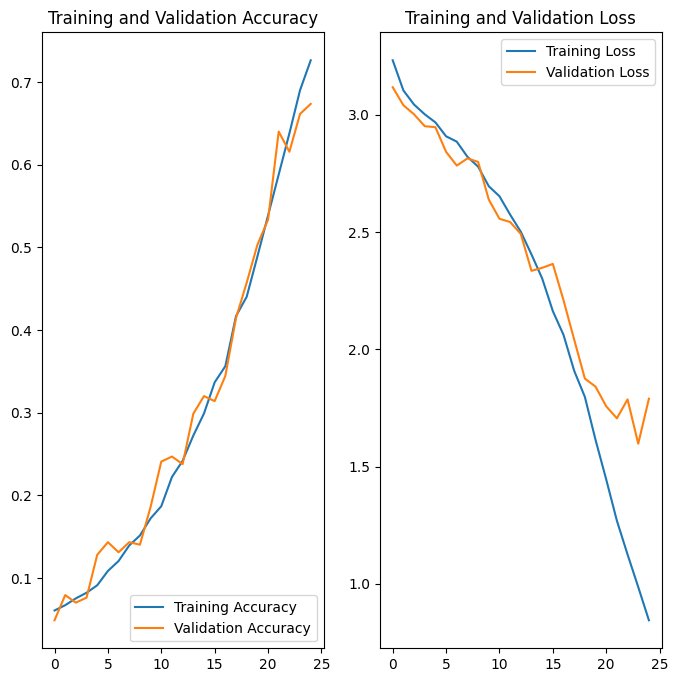

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: falafel
1/1 [==============================] - 0s 188ms/step
predicted label: falafel


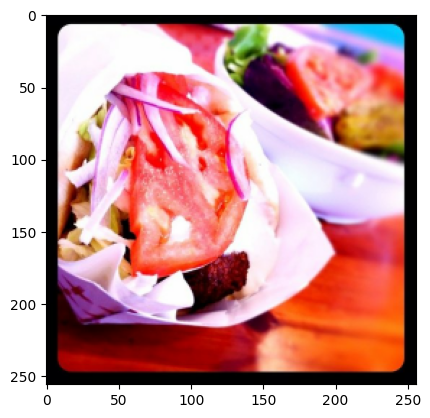

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


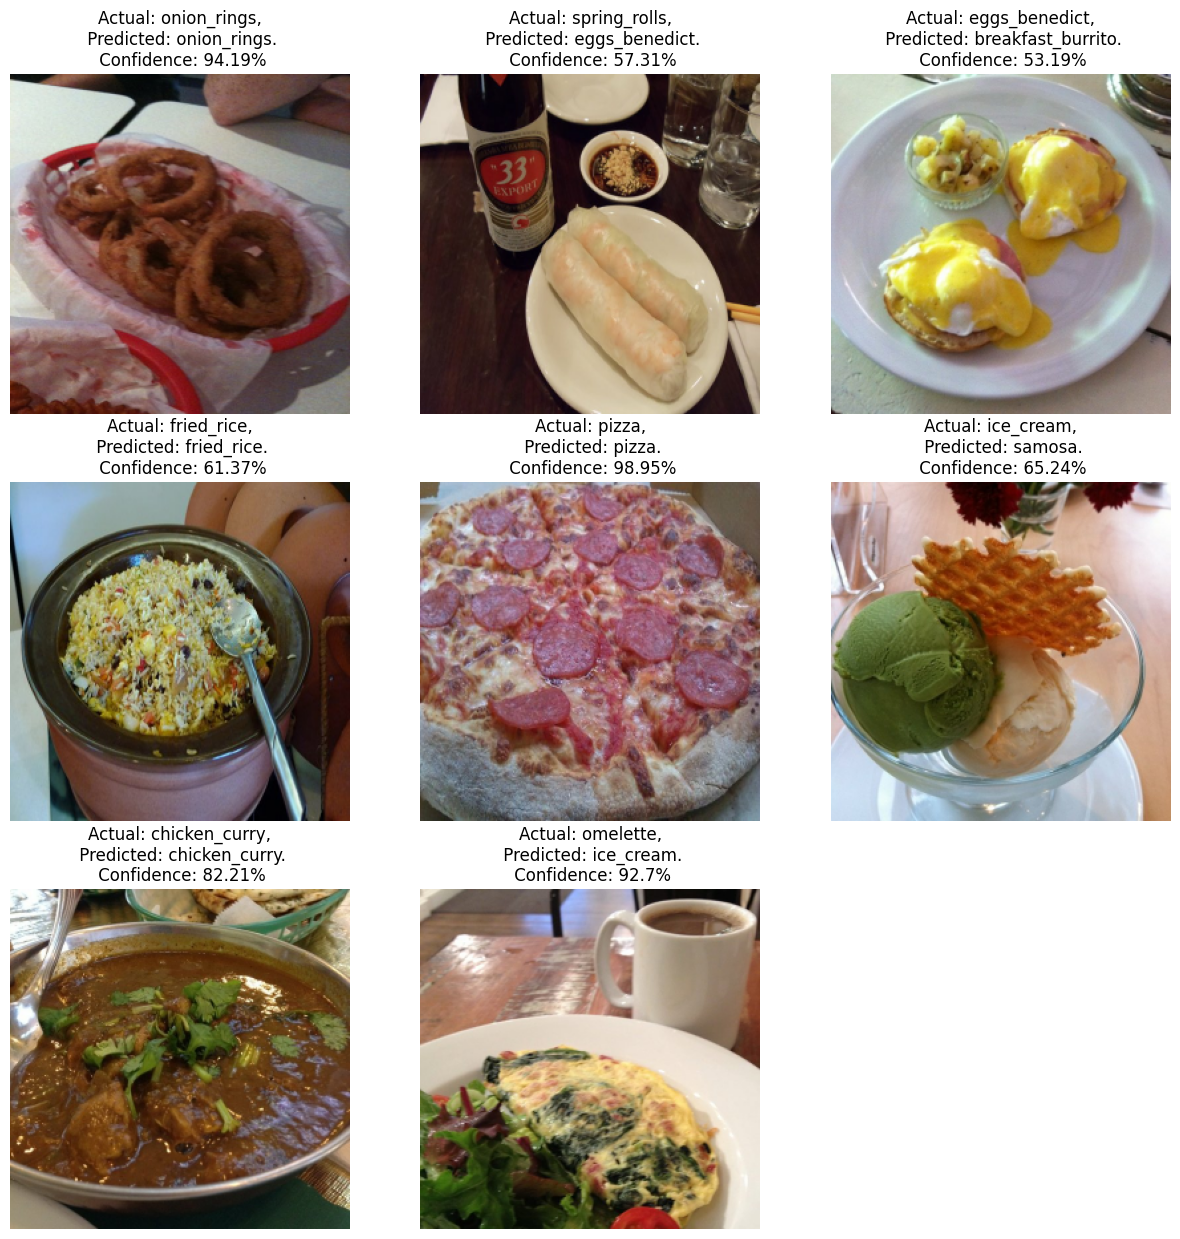

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
pip install scikit-learn


     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.4 kB 330.3 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.4 kB 330.3 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.4 kB 245.8 kB/s eta 0:00:01
     -------------------------------- ----- 51.2/60.4 kB 201.8 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 229.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.2 MB 1.3 MB/s eta 0:00:08
   ---------------------------------------- 0.1/9.2 MB 1.3 MB/s eta 0:00:08
   ---------------------------------------- 0.1/9.2 MB 1.3 MB/s eta 0:00:08
    --------------------------------------- 0.1/9.2 MB 654.9 kB/s eta 0:00:14
    ---

In [47]:
pip install seaborn


     ---------------------------------------- 0.0/341.8 kB ? eta -:--:--
     - -------------------------------------- 10.2/341.8 kB ? eta -:--:--
     --- ----------------------------------- 30.7/341.8 kB 1.4 MB/s eta 0:00:01
     ---- -------------------------------- 41.0/341.8 kB 667.8 kB/s eta 0:00:01
     ---- -------------------------------- 41.0/341.8 kB 667.8 kB/s eta 0:00:01
     ------- ----------------------------- 71.7/341.8 kB 438.9 kB/s eta 0:00:01
     ------------ ----------------------- 122.9/341.8 kB 602.4 kB/s eta 0:00:01
     --------------- -------------------- 143.4/341.8 kB 655.8 kB/s eta 0:00:01
     -------------------- --------------- 194.6/341.8 kB 655.9 kB/s eta 0:00:01
     ------------------------ ----------- 235.5/341.8 kB 686.8 kB/s eta 0:00:01
     ----------------------------- ------ 276.5/341.8 kB 776.2 kB/s eta 0:00:01
     ------------------------------ ----- 286.7/341.8 kB 681.0 kB/s eta 0:00:01
     ------------------------------------ 341.8/341.8

In [48]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [49]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)


43/43 [==============================] - 3s 58ms/step


In [50]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)


In [51]:
cm = confusion_matrix(y_true, y_pred)


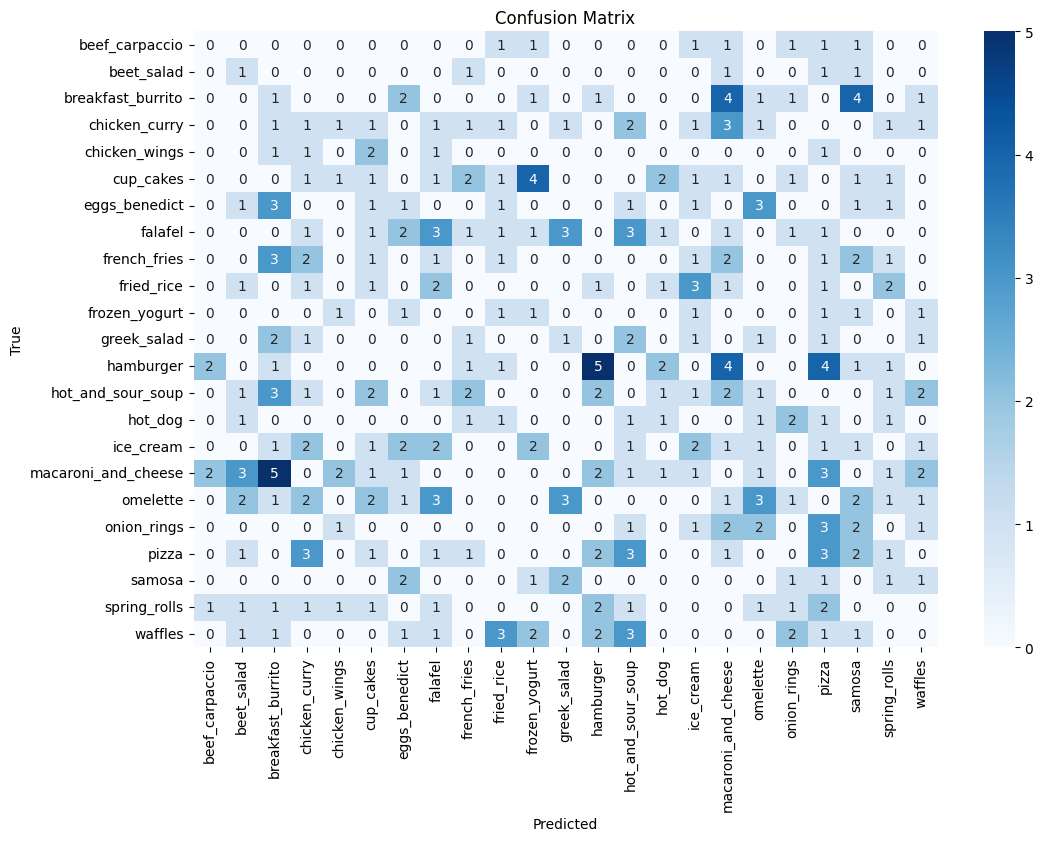

In [52]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [53]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


                     precision    recall  f1-score   support

     beef_carpaccio       0.00      0.00      0.00         7
         beet_salad       0.08      0.20      0.11         5
  breakfast_burrito       0.04      0.06      0.05        16
      chicken_curry       0.06      0.06      0.06        17
      chicken_wings       0.00      0.00      0.00         6
          cup_cakes       0.06      0.06      0.06        18
      eggs_benedict       0.08      0.07      0.07        14
            falafel       0.17      0.15      0.16        20
       french_fries       0.00      0.00      0.00        15
         fried_rice       0.00      0.00      0.00        14
      frozen_yogurt       0.08      0.12      0.10         8
        greek_salad       0.10      0.09      0.10        11
          hamburger       0.29      0.23      0.26        22
  hot_and_sour_soup       0.00      0.00      0.00        20
            hot_dog       0.11      0.10      0.11        10
          ice_cream    

In [36]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/6\assets


INFO:tensorflow:Assets written to: ../models/6\assets


In [58]:
model.save("../food.h5")

1/1 [==============================] - 0s 97ms/step


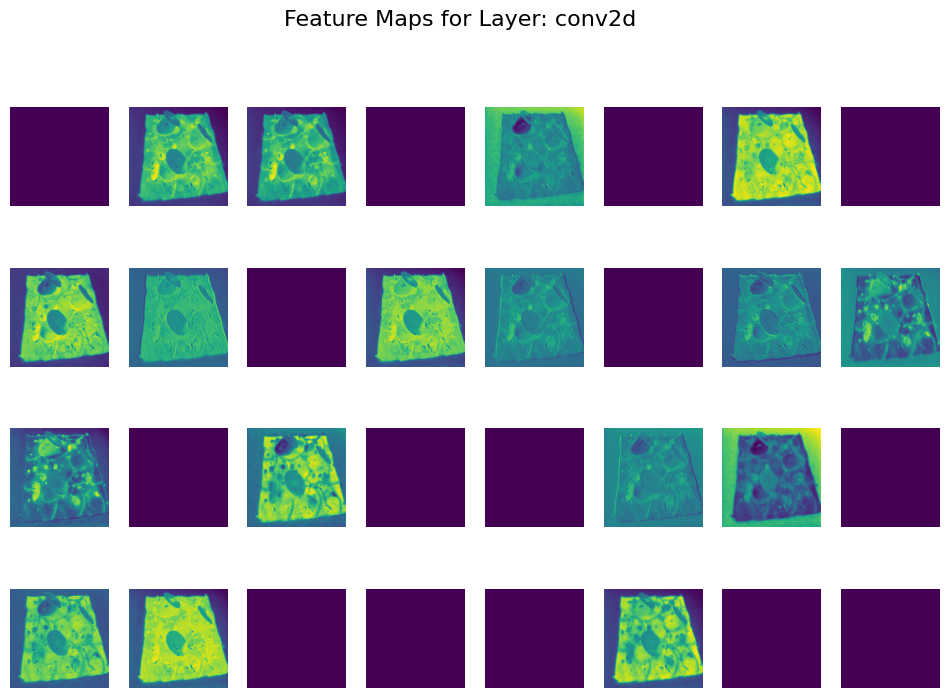

ValueError: num must be an integer with 1 <= num <= 32, not 33

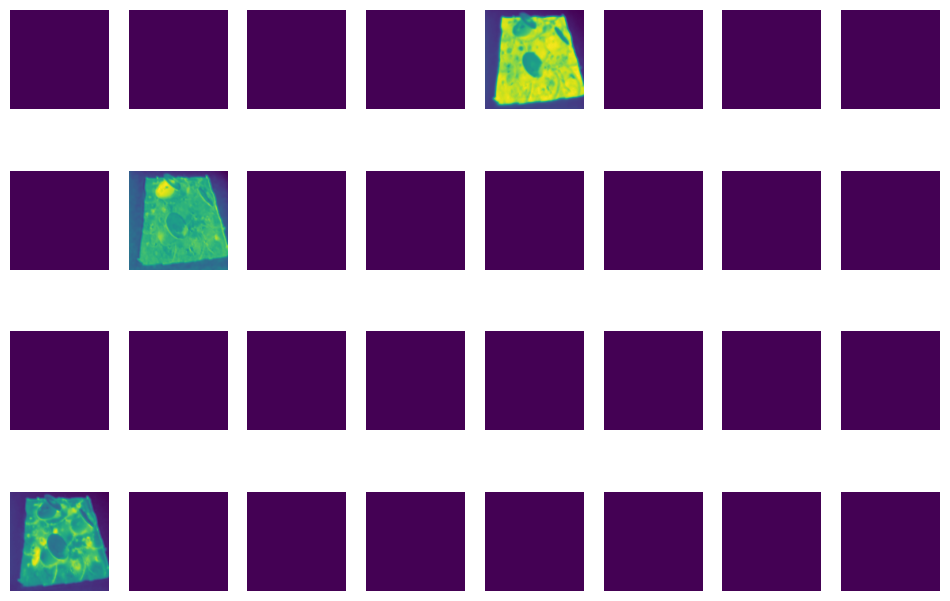

In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('../food.h5')  # Replace with the path to your saved model

# Load and preprocess the image for visualization
image_path = 'C:\\Users\\Rinas\\FoodFinal1\\FoodFinal\\training\\FoodImages\\beef_carpaccio\\146166.jpg'  # Replace with the path to your image
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)  # Assuming RGB image
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
image = tf.expand_dims(image, axis=0)  # Add batch dimension

# Define a function to generate feature maps
def visualize_feature_maps(model, image):
    # Create a list of layer names for the layers you want to visualize
    layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name]

    # Create a model that outputs the feature maps for the selected layers
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output for layer_name in layer_names])

    # Get the feature maps for the input image
    feature_maps = intermediate_model.predict(image)

    # Plot the feature maps
    for i, layer_name in enumerate(layer_names):
        plt.figure(figsize=(12, 8))
        for j in range(feature_maps[i].shape[-1]):
            plt.subplot(4, 8, j + 1)
            plt.imshow(feature_maps[i][0, :, :, j], cmap='viridis')
            plt.axis('off')
        plt.suptitle(f'Feature Maps for Layer: {layer_name}', fontsize=16)
        plt.show()

# Visualize feature maps for the given image
visualize_feature_maps(model, image)


In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras import layers, Model

# # Load the pre-trained VGG16 model with weights from ImageNet
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


In [ ]:
# for layer in base_model.layers:
#     layer.trainable = False  # You can choose which layers to freeze or unfreeze


In [ ]:
# x = layers.Flatten()(base_model.output)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)  # Optional dropout layer for regularization
# output = layers.Dense(23, activation='softmax')(x)  # Replace 'num_classes' with the number of your classes

# model = Model(base_model.input, output)


In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras import layers, Model

# # Define the number of classes in your dataset
# num_classes = 23  # Adjust this to match your dataset

# # Load the pre-trained VGG16 model with weights from ImageNet
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# # Freeze the pre-trained layers
# for layer in base_model.layers:
#     layer.trainable = False

# # Add custom classification layers
# x = layers.Flatten()(base_model.output)
# x = layers.Dense(256, activation='relu')(x)
# output = layers.Dense(num_classes, activation='softmax')(x)

# # Create the model
# model = Model(base_model.input, output)

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=val_ds,
#     verbose=1
# )



In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


In [26]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


In [27]:
# Load the ResNet-50 model pre-trained on ImageNet data
base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Create a new top for fine-tuning
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = data_augmentation(input_layer)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [29]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/30
332/332 [==============================] - 168s 486ms/step - loss: 1.7816 - accuracy: 0.4964 - val_loss: 0.8716 - val_accuracy: 0.7287
Epoch 2/30
332/332 [==============================] - 165s 499ms/step - loss: 1.0040 - accuracy: 0.6979 - val_loss: 0.7185 - val_accuracy: 0.7805
Epoch 3/30
332/332 [==============================] - 163s 490ms/step - loss: 0.7546 - accuracy: 0.7665 - val_loss: 0.6522 - val_accuracy: 0.8049
Epoch 4/30
332/332 [==============================] - 163s 491ms/step - loss: 0.6575 - accuracy: 0.7925 - val_loss: 0.5714 - val_accuracy: 0.8049
Epoch 5/30
332/332 [==============================] - 163s 492ms/step - loss: 0.5327 - accuracy: 0.8234 - val_loss: 0.4521 - val_accuracy: 0.8598
Epoch 6/30
332/332 [==============================] - 163s 492ms/step - loss: 0.4629 - accuracy: 0.8482 - val_loss: 0.4647 - val_accuracy: 0.8506
Epoch 7/30
332/332 [==============================] - 163s 492ms/step - loss: 0.4083 - accuracy: 0.8633 - val_loss: 0.4545 -

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

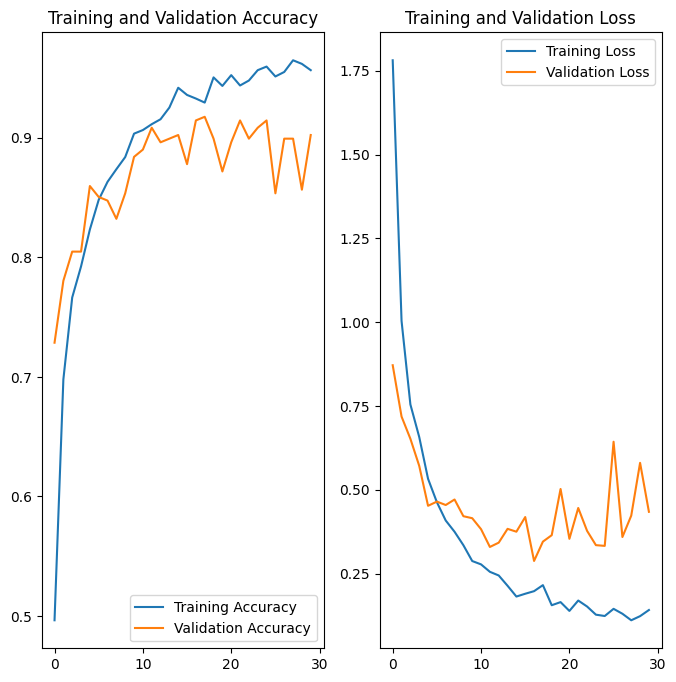

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
scores = model.evaluate(test_ds)

43/43 [==============================] - 22s 461ms/step - loss: 0.4251 - accuracy: 0.9096


first image to predict
actual label: frozen_yogurt
1/1 [==============================] - 1s 721ms/step
predicted label: frozen_yogurt


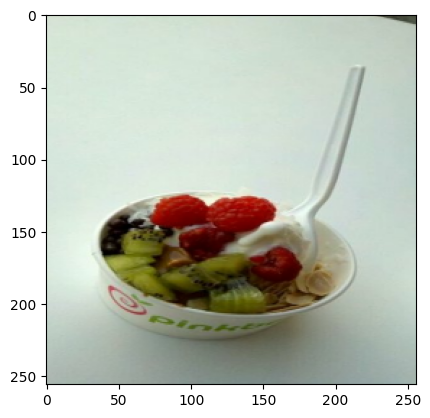

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 213ms/step


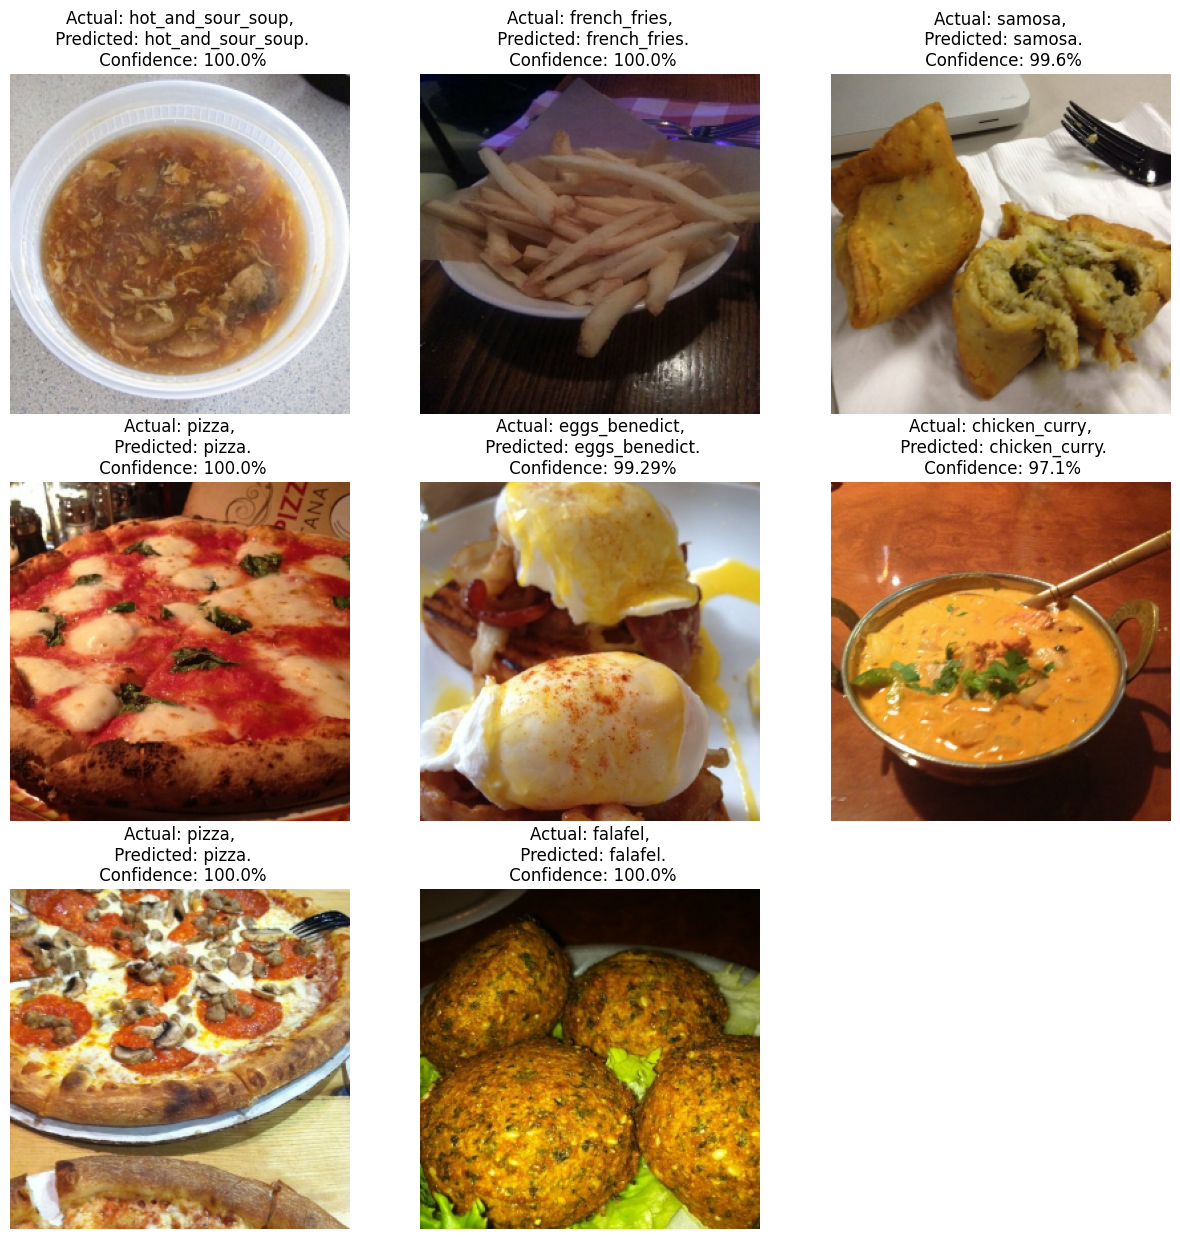

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [41]:
model.save("../food1.h5")

C:\Users\Rinas\anaconda3\envs\tenserfloww\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


In [43]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Preprocessing for MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [44]:
# Load the MobileNetV2 model pre-trained on ImageNet data
base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Create a new top for fine-tuning
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = data_augmentation(input_layer)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


9406464/9406464 [==============================] - 12s 1us/step


In [45]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/30
332/332 [==============================] - 64s 180ms/step - loss: 1.5492 - accuracy: 0.5484 - val_loss: 0.7145 - val_accuracy: 0.7927
Epoch 2/30
332/332 [==============================] - 56s 170ms/step - loss: 0.8884 - accuracy: 0.7371 - val_loss: 0.6652 - val_accuracy: 0.8018
Epoch 3/30
332/332 [==============================] - 57s 170ms/step - loss: 0.7055 - accuracy: 0.7736 - val_loss: 0.5490 - val_accuracy: 0.8201
Epoch 4/30
332/332 [==============================] - 57s 171ms/step - loss: 0.5627 - accuracy: 0.8177 - val_loss: 0.4193 - val_accuracy: 0.8841
Epoch 5/30
332/332 [==============================] - 58s 175ms/step - loss: 0.4580 - accuracy: 0.8580 - val_loss: 0.4139 - val_accuracy: 0.8811
Epoch 6/30
332/332 [==============================] - 58s 176ms/step - loss: 0.4086 - accuracy: 0.8614 - val_loss: 0.3626 - val_accuracy: 0.8811
Epoch 7/30
332/332 [==============================] - 58s 176ms/step - loss: 0.3614 - accuracy: 0.8783 - val_loss: 0.3583 - val_ac

In [46]:
scores = model.evaluate(test_ds)

43/43 [==============================] - 8s 187ms/step - loss: 0.4117 - accuracy: 0.8980


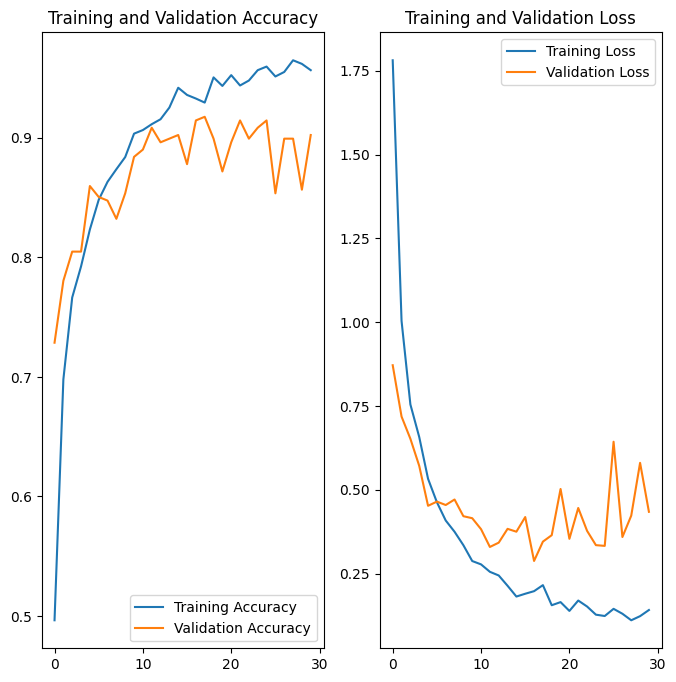

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
model.save("../food3.h5")

C:\Users\Rinas\anaconda3\envs\tenserfloww\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


In [51]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Preprocessing for Xception
preprocess_input = tf.keras.applications.xception.preprocess_input


In [52]:
# Load the Xception model pre-trained on ImageNet data
base_model = Xception(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Create a new top for fine-tuning
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = data_augmentation(input_layer)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


83683744/83683744 [==============================] - 142s 2us/step


In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/30
 19/332 [>.............................] - ETA: 2:24 - loss: 3.0695 - accuracy: 0.1776

In [23]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Preprocessing for DenseNet-121
preprocess_input = tf.keras.applications.densenet.preprocess_input


In [24]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Preprocessing for DenseNet-121
preprocess_input = tf.keras.applications.densenet.preprocess_input


In [26]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


In [ ]:
# Load the DenseNet-121 model pre-trained on ImageNet data
base_model = DenseNet121(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Create a new top for fine-tuning
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = data_augmentation(input_layer)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


27729920/29084464 [===========================>..] - ETA: 1s

In [28]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


In [29]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Preprocessing for InceptionV3
preprocess_input = tf.keras.applications.inception_v3.preprocess_input


In [30]:
# Load the InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Create a new top for fine-tuning
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = data_augmentation(input_layer)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


87910968/87910968 [==============================] - 174s 2us/step


In [31]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/20
332/332 [==============================] - 92s 263ms/step - loss: 1.7599 - accuracy: 0.4972 - val_loss: 1.1383 - val_accuracy: 0.6677
Epoch 2/20
332/332 [==============================] - 82s 247ms/step - loss: 1.1573 - accuracy: 0.6516 - val_loss: 1.0233 - val_accuracy: 0.7104
Epoch 3/20
332/332 [==============================] - 84s 252ms/step - loss: 0.9940 - accuracy: 0.6976 - val_loss: 0.9026 - val_accuracy: 0.7256
Epoch 4/20
332/332 [==============================] - 84s 253ms/step - loss: 0.9014 - accuracy: 0.7307 - val_loss: 0.9125 - val_accuracy: 0.7378
Epoch 5/20
332/332 [==============================] - 84s 253ms/step - loss: 0.8483 - accuracy: 0.7307 - val_loss: 0.7782 - val_accuracy: 0.7470
Epoch 6/20
332/332 [==============================] - 85s 255ms/step - loss: 0.7655 - accuracy: 0.7695 - val_loss: 0.8096 - val_accuracy: 0.7470
Epoch 7/20
332/332 [==============================] - 84s 254ms/step - loss: 0.7318 - accuracy: 0.7733 - val_loss: 0.7740 - val_ac

In [32]:
scores = model.evaluate(test_ds)

43/43 [==============================] - 14s 256ms/step - loss: 0.5429 - accuracy: 0.8397


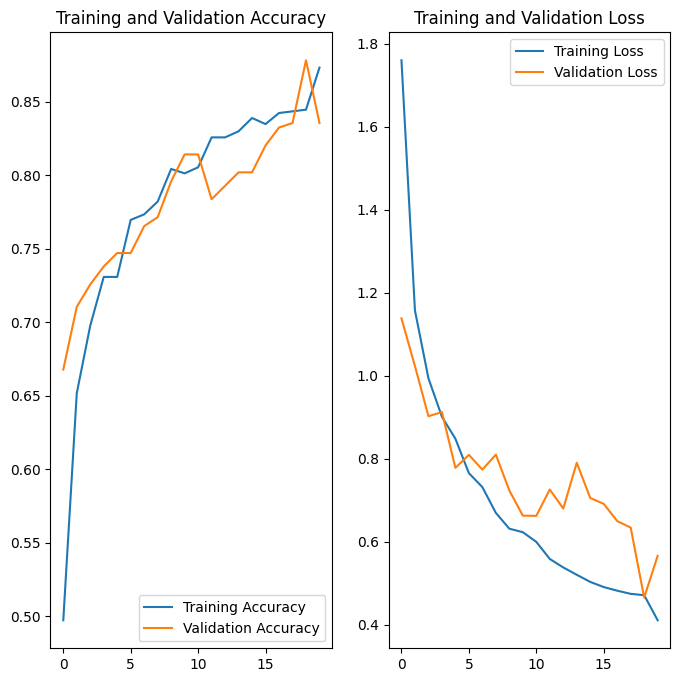

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
model.save("../food4.h5")

C:\Users\Rinas\anaconda3\envs\tenserfloww\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [39]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

43/43 [==============================] - 14s 262ms/step


In [40]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [41]:
cm = confusion_matrix(y_true, y_pred)

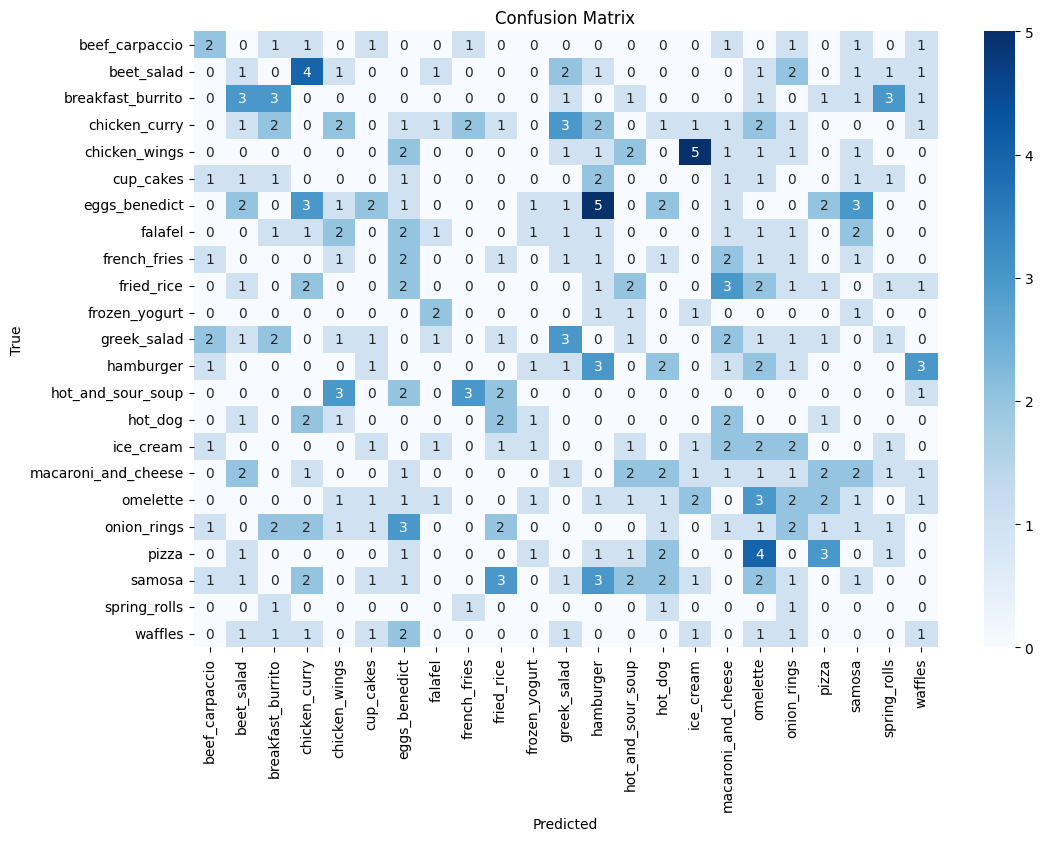

In [42]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [43]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


                     precision    recall  f1-score   support

     beef_carpaccio       0.20      0.20      0.20        10
         beet_salad       0.06      0.06      0.06        16
  breakfast_burrito       0.21      0.20      0.21        15
      chicken_curry       0.00      0.00      0.00        22
      chicken_wings       0.00      0.00      0.00        15
          cup_cakes       0.00      0.00      0.00        10
      eggs_benedict       0.05      0.04      0.04        24
            falafel       0.12      0.07      0.09        15
       french_fries       0.00      0.00      0.00        13
         fried_rice       0.00      0.00      0.00        17
      frozen_yogurt       0.00      0.00      0.00         6
        greek_salad       0.18      0.16      0.17        19
          hamburger       0.13      0.19      0.15        16
  hot_and_sour_soup       0.00      0.00      0.00        11
            hot_dog       0.00      0.00      0.00        10
          ice_cream    

1/1 [==============================] - 0s 194ms/step


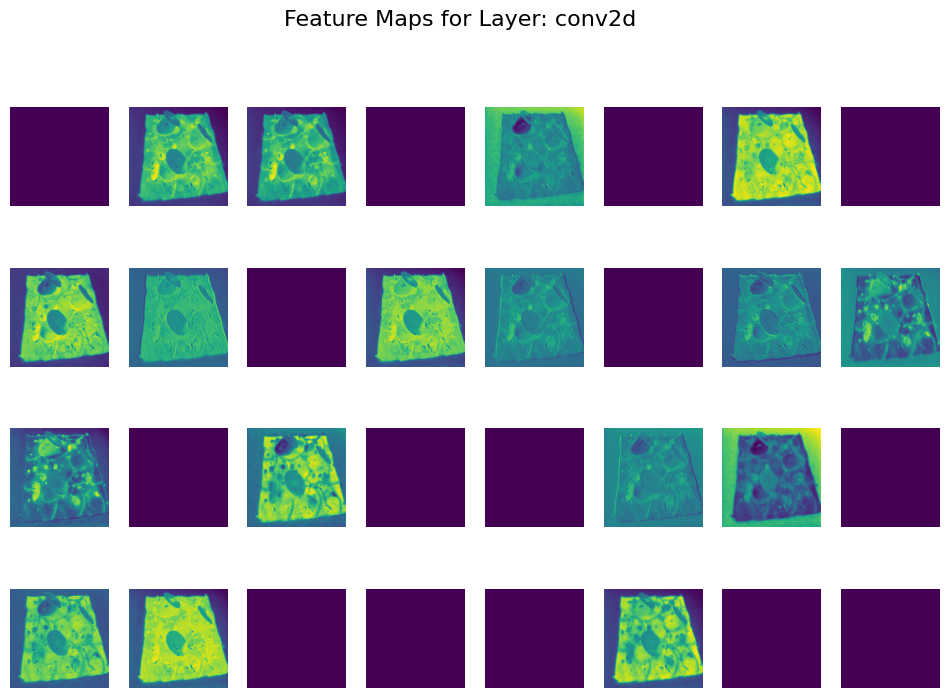

ValueError: num must be an integer with 1 <= num <= 32, not 33

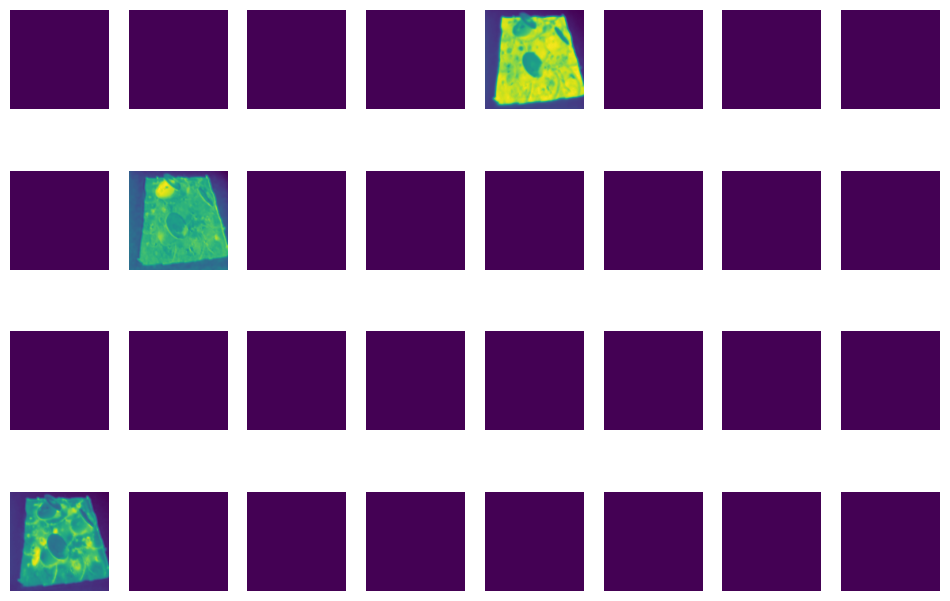

In [44]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('../food.h5')  # Replace with the path to your saved model

# Load and preprocess the image for visualization
image_path = 'C:\\Users\\Rinas\\FoodFinal1\\FoodFinal\\training\\FoodImages\\beef_carpaccio\\146166.jpg'  # Replace with the path to your image
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)  # Assuming RGB image
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
image = tf.expand_dims(image, axis=0)  # Add batch dimension

# Define a function to generate feature maps
def visualize_feature_maps(model, image):
    # Create a list of layer names for the layers you want to visualize
    layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name]

    # Create a model that outputs the feature maps for the selected layers
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output for layer_name in layer_names])

    # Get the feature maps for the input image
    feature_maps = intermediate_model.predict(image)

    # Plot the feature maps
    for i, layer_name in enumerate(layer_names):
        plt.figure(figsize=(12, 8))
        for j in range(feature_maps[i].shape[-1]):
            plt.subplot(4, 8, j + 1)
            plt.imshow(feature_maps[i][0, :, :, j], cmap='viridis')
            plt.axis('off')
        plt.suptitle(f'Feature Maps for Layer: {layer_name}', fontsize=16)
        plt.show()

# Visualize feature maps for the given image
visualize_feature_maps(model, image)
